# Pneumonia Classification on Chest X-Rays using DreamAI

## Imports

In [1]:
import sys

# Make sure to change this path to your folder with DreamAI

sys.path.insert(0, '/home/farhan/hamza/dreamai/') # Folder with DreamAI

# Things below are all included in the dreamai folder

import cv_model
import utils
import obj_utils
from dai_imports import*

%load_ext autoreload
%autoreload 2

Your dataset folder, in this case I've named it 'github_chest_xray' should look something like this:

![title](xray_folder.png)

Setup the necessary paths.

All the train,val,test dataframes will be saved in the folder with the dataset. All the best model files will be saved in the current directory by default.

'train_name' is the folder with ALL of the images. DreamAI requires all of the images to be in one single folder.

If the data is in the Keras format, as is the case with this dataset and most Kaggle datasets, that will be handled in the DataProcessor function below.

In [2]:
data_path = Path('/home/farhan/hamza/github_chest_xray/')
train_name = 'train'
val_name = 'val'
test_name = 'test'
dp_name = 'DP_chest_xray.pkl'
train_path = data_path/train_name
val_path = data_path/val_name
test_path = data_path/test_name
dp_path = data_path/dp_name

## Data Setup

Here, we will use DreamAI's data processor to move all the images into one folder and create dataframes for train,val, and test.

Everything under the 'Data Setup' heading should be run only once, after that you can comment this part out and start with 'Load and Use the Data'.

In [6]:
DP = data_processing.DataProcessor(data_path,train_csv=None,tr_name=train_name,setup_data=True)

data_processing.save_obj(DP,dp_path)

+------------------------------------+
|              Dream AI              |
+------------------------------------+


Single-label Classification



## Load and Use the Data

In [3]:
# Load our saved DataProcessor object

DP = data_processing.load_obj(dp_path)

In [4]:
# Dictionary with information about the data

data_dict = DP.data_dict

Our Label has been changed from 'NORMAL' and 'PNEUMONIA' to 0 and 1.

In [5]:
data_dict['data_dfs'][train_name].head()

,Img,Label
0,train_IM-0432-0001.jpeg,0
1,train_IM-0370-0001.jpeg,0
2,train_person1308_bacteria_3286.jpeg,1
3,train_person111_virus_210.jpeg,1
4,train_person437_bacteria_1884.jpeg,1


In [6]:
data_dict['data_dfs'][val_name].head()

,Img,Label
0,val_NORMAL2-IM-1431-0001.jpeg,0
1,val_person1950_bacteria_4881.jpeg,1
2,val_NORMAL2-IM-1430-0001.jpeg,0
3,val_NORMAL2-IM-1427-0001.jpeg,0
4,val_NORMAL2-IM-1438-0001.jpeg,0


In [7]:
image_size = (256,256)
bs = 32

# This is just a precaution for when normalizing the data
# This is the percentage of the data to use when calculating the mean and standard deviation
# so that it doesn't exceed our memory capacity
# 2500000 is a safe number that usually works for me with a 64GB RAM. It will differ for your system

stats_percentage = min(1.0,2500000/(image_size[0] * len(data_dict['data_dfs'][train_name])))
stats_percentage

1.0

In [8]:
# Create dataset and dataloaders
# This may take a while because it will normalize according to the whole dataset

sets,loaders,sizes = DP.get_data(data_dict, image_size, bs = bs,
                                 balance = True, stats_percentage = stats_percentage)

In [9]:
sizes

{'train': 5216, 'val': 16, 'test': 624}

In [10]:
# Number of batches to print progress after

print_every = sizes[train_name]//3//bs
print_every

54

## Model Setup

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = cv_model.TransferNetworkImg(model_name='resnet50',model_type='classifier',one_cycle_factor=None,
                        optimizer_name='sgd',criterion = nn.CrossEntropyLoss(), device=device,
                        best_model_file = 'best_chest_xray_sgd.pth',
                        class_names=data_dict['class_names'],num_classes=data_dict['num_classes'],
                        dropout_p = 0.5,add_extra=True,
                        head = {'num_outputs':data_dict['num_classes'],'model_type':'classifier',
                                'layers':[]})

Setting transfer learning model: self.model set to resnet50
Model: resnet50, Setting head: inputs: 2048 hidden:[] outputs: 2
Transfer Learning: current best accuracy = 0.000
Setting optimizer: SGD


Uncomment these lines when you want to retrain or just use the model for predictions.

In [12]:
# net.load_state_dict(torch.load('best_chest_xray_sgd.pth'))
# net.optimizer.load_state_dict(torch.load('best_chest_xray_sgd_optim.pth'))

In [13]:
net.unfreeze()


Finding the ideal learning rate.


/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

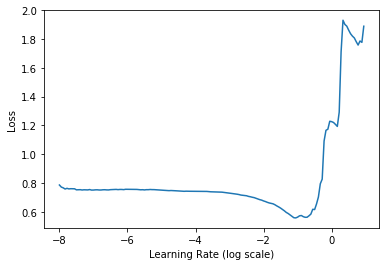

Found it: 0.006812920690579657



0.006812920690579657

In [14]:
# Find and set the ideal learning rate

lr = net.find_lr(loaders[train_name],plot=True)
net.optimizer.param_groups[0]['lr'] = lr
net.optimizer.param_groups[0]['lr']

## Train

In [15]:
net.fit(loaders[train_name],loaders[val_name],epochs=10,print_every=print_every)

Epoch:  1/10



/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTenso

+----------------------------------------------------------------------+
06:22:27
Time elapsed: 42.362 sec
Epoch:1/10
Batch: 55/163
Batch training time: 42.362 sec
Batch training loss: 0.181
Average training loss: 0.364
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
06:23:08
Time elapsed: 1.383 min
Epoch:1/10
Batch: 109/163
Batch training time: 40.593 sec
Batch training loss: 0.067
Average training loss: 0.256
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
06:23:48
Time elapsed: 2.059 min
Epoch:1/10
Batch: 163/163
Batch training time: 40.580 sec
Batch training loss: 0.087
Average training loss: 0.208
+----------------------------------------------------------------------+



/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)



////////////////////////////////////
06:23:51
Epoch 1/10
Validation time: 1.228 sec
Epoch training loss: 0.207
Epoch validation loss: 0.150
Validation accuracy: 100.000
\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


**********Updating best accuracy**********

Previous best: 0.000
New best: 100.000

******************************************

Epoch:  2/10



/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTenso

+----------------------------------------------------------------------+
06:24:36
Time elapsed: 42.120 sec
Epoch:2/10
Batch: 55/163
Batch training time: 42.120 sec
Batch training loss: 0.020
Average training loss: 0.073
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
06:25:16
Time elapsed: 1.379 min
Epoch:2/10
Batch: 109/163
Batch training time: 40.603 sec
Batch training loss: 0.032
Average training loss: 0.076
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
06:25:57
Time elapsed: 2.055 min
Epoch:2/10
Batch: 163/163
Batch training time: 40.603 sec
Batch training loss: 0.026
Average training loss: 0.072
+----------------------------------------------------------------------+



/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)



////////////////////////////////////
06:25:59
Epoch 2/10
Validation time: 1.221 sec
Epoch training loss: 0.072
Epoch validation loss: 0.171
Validation accuracy: 93.750
\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

Epoch:  3/10



/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTenso

+----------------------------------------------------------------------+
06:26:41
Time elapsed: 42.230 sec
Epoch:3/10
Batch: 55/163
Batch training time: 42.230 sec
Batch training loss: 0.015
Average training loss: 0.053
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
06:27:22
Time elapsed: 1.382 min
Epoch:3/10
Batch: 109/163
Batch training time: 40.685 sec
Batch training loss: 0.011
Average training loss: 0.046
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
06:28:03
Time elapsed: 2.060 min
Epoch:3/10
Batch: 163/163
Batch training time: 40.662 sec
Batch training loss: 0.083
Average training loss: 0.045
+----------------------------------------------------------------------+



/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)



////////////////////////////////////
06:28:05
Epoch 3/10
Validation time: 1.222 sec
Epoch training loss: 0.044
Epoch validation loss: 0.109
Validation accuracy: 100.000
\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


**********Updating best accuracy**********

Previous best: 100.000
New best: 100.000

******************************************

Epoch:  4/10



/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

+----------------------------------------------------------------------+
06:28:50
Time elapsed: 42.297 sec
Epoch:4/10
Batch: 55/163
Batch training time: 42.297 sec
Batch training loss: 0.016
Average training loss: 0.032
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
06:29:31
Time elapsed: 1.382 min
Epoch:4/10
Batch: 109/163
Batch training time: 40.642 sec
Batch training loss: 0.008
Average training loss: 0.031
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
06:30:11
Time elapsed: 2.060 min
Epoch:4/10
Batch: 163/163
Batch training time: 40.638 sec
Batch training loss: 0.007
Average training loss: 0.033
+----------------------------------------------------------------------+



/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)



////////////////////////////////////
06:30:13
Epoch 4/10
Validation time: 1.236 sec
Epoch training loss: 0.033
Epoch validation loss: 0.035
Validation accuracy: 100.000
\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


**********Updating best accuracy**********

Previous best: 100.000
New best: 100.000

******************************************

Epoch:  5/10



/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

+----------------------------------------------------------------------+
06:30:59
Time elapsed: 42.204 sec
Epoch:5/10
Batch: 55/163
Batch training time: 42.204 sec
Batch training loss: 0.005
Average training loss: 0.024
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
06:31:39
Time elapsed: 1.381 min
Epoch:5/10
Batch: 109/163
Batch training time: 40.648 sec
Batch training loss: 0.002
Average training loss: 0.025
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
06:32:20
Time elapsed: 2.059 min
Epoch:5/10
Batch: 163/163
Batch training time: 40.662 sec
Batch training loss: 0.036
Average training loss: 0.023
+----------------------------------------------------------------------+



/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)



////////////////////////////////////
06:32:22
Epoch 5/10
Validation time: 1.227 sec
Epoch training loss: 0.023
Epoch validation loss: 0.076
Validation accuracy: 100.000
\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


**********Updating best accuracy**********

Previous best: 100.000
New best: 100.000

******************************************

Epoch:  6/10



/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTenso

+----------------------------------------------------------------------+
06:33:07
Time elapsed: 42.388 sec
Epoch:6/10
Batch: 55/163
Batch training time: 42.388 sec
Batch training loss: 0.011
Average training loss: 0.018
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
06:33:48
Time elapsed: 1.384 min
Epoch:6/10
Batch: 109/163
Batch training time: 40.634 sec
Batch training loss: 0.079
Average training loss: 0.016
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
06:34:29
Time elapsed: 2.061 min
Epoch:6/10
Batch: 163/163
Batch training time: 40.628 sec
Batch training loss: 0.004
Average training loss: 0.016
+----------------------------------------------------------------------+



/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)



////////////////////////////////////
06:34:31
Epoch 6/10
Validation time: 1.226 sec
Epoch training loss: 0.017
Epoch validation loss: 0.049
Validation accuracy: 100.000
\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


**********Updating best accuracy**********

Previous best: 100.000
New best: 100.000

******************************************

Epoch:  7/10



/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

+----------------------------------------------------------------------+
06:35:16
Time elapsed: 42.094 sec
Epoch:7/10
Batch: 55/163
Batch training time: 42.094 sec
Batch training loss: 0.005
Average training loss: 0.016
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
06:35:56
Time elapsed: 1.379 min
Epoch:7/10
Batch: 109/163
Batch training time: 40.638 sec
Batch training loss: 0.001
Average training loss: 0.012
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
06:36:37
Time elapsed: 2.056 min
Epoch:7/10
Batch: 163/163
Batch training time: 40.637 sec
Batch training loss: 0.004
Average training loss: 0.013
+----------------------------------------------------------------------+



/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)



////////////////////////////////////
06:36:39
Epoch 7/10
Validation time: 1.216 sec
Epoch training loss: 0.013
Epoch validation loss: 0.015
Validation accuracy: 100.000
\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


**********Updating best accuracy**********

Previous best: 100.000
New best: 100.000

******************************************

Epoch:  8/10



/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

+----------------------------------------------------------------------+
06:37:25
Time elapsed: 42.559 sec
Epoch:8/10
Batch: 55/163
Batch training time: 42.559 sec
Batch training loss: 0.002
Average training loss: 0.007
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
06:38:05
Time elapsed: 1.386 min
Epoch:8/10
Batch: 109/163
Batch training time: 40.597 sec
Batch training loss: 0.002
Average training loss: 0.008
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
06:38:46
Time elapsed: 2.063 min
Epoch:8/10
Batch: 163/163
Batch training time: 40.628 sec
Batch training loss: 0.002
Average training loss: 0.009
+----------------------------------------------------------------------+



/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)



////////////////////////////////////
06:38:48
Epoch 8/10
Validation time: 1.222 sec
Epoch training loss: 0.009
Epoch validation loss: 0.026
Validation accuracy: 100.000
\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


**********Updating best accuracy**********

Previous best: 100.000
New best: 100.000

******************************************

Epoch:  9/10



/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

+----------------------------------------------------------------------+
06:39:33
Time elapsed: 42.327 sec
Epoch:9/10
Batch: 55/163
Batch training time: 42.327 sec
Batch training loss: 0.001
Average training loss: 0.009
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
06:40:14
Time elapsed: 1.383 min
Epoch:9/10
Batch: 109/163
Batch training time: 40.667 sec
Batch training loss: 0.002
Average training loss: 0.008
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
06:40:55
Time elapsed: 2.061 min
Epoch:9/10
Batch: 163/163
Batch training time: 40.676 sec
Batch training loss: 0.061
Average training loss: 0.007
+----------------------------------------------------------------------+



/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)



////////////////////////////////////
06:40:57
Epoch 9/10
Validation time: 1.208 sec
Epoch training loss: 0.007
Epoch validation loss: 0.016
Validation accuracy: 100.000
\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


**********Updating best accuracy**********

Previous best: 100.000
New best: 100.000

******************************************

Epoch: 10/10



/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

+----------------------------------------------------------------------+
06:41:42
Time elapsed: 42.317 sec
Epoch:10/10
Batch: 55/163
Batch training time: 42.317 sec
Batch training loss: 0.001
Average training loss: 0.009
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
06:42:23
Time elapsed: 1.383 min
Epoch:10/10
Batch: 109/163
Batch training time: 40.657 sec
Batch training loss: 0.003
Average training loss: 0.006
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
06:43:03
Time elapsed: 2.061 min
Epoch:10/10
Batch: 163/163
Batch training time: 40.655 sec
Batch training loss: 0.002
Average training loss: 0.007
+----------------------------------------------------------------------+



/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)



////////////////////////////////////
06:43:05
Epoch 10/10
Validation time: 1.221 sec
Epoch training loss: 0.006
Epoch validation loss: 0.105
Validation accuracy: 93.750
\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


Loading best model



In [16]:
# Save the 'cv_model.TransferNetworkImg' object for later

data_processing.save_obj(net,'best_chest_xray_net.pkl')

## Evaluation

As you can see, the accuracy quickly hit 100%, but the loss was constantly falling. Let's evaluate our model after training for only 10 epochs.

In [17]:
eval_dict = net.evaluate(loaders[test_name])

/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

In [24]:
print(eval_dict['accuracy'])

89.58333333333333


In [22]:
print(eval_dict['class_accuracies'])

[('NORMAL', 73.07692307692307), ('PNEUMONIA', 99.48717948717949)]


In [46]:
# Recall is very important in medical use cases and our model has 0.99 recall on x-rays labelled PNEUMONIA

print(eval_dict['report'])

              precision    recall  f1-score   support

      NORMAL       0.98      0.60      0.75       234
   PNEUMONIA       0.81      0.99      0.89       390

   micro avg       0.85      0.85      0.85       624
   macro avg       0.89      0.80      0.82       624
weighted avg       0.87      0.85      0.84       624



In [23]:
print(eval_dict['confusion_matrix'])

[[171  63]
 [  2 388]]


In [49]:
eval_dict['roc_auc_score']

0.7974358974358975

Let's visualize the data distribution.

Note: DreamAI uses data augmentation to balance the data while training.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2300212710>]],
      dtype=object)

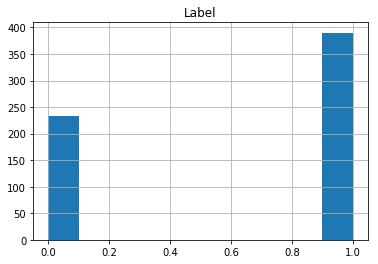

In [27]:
data_dict['data_dfs'][test_name].hist()

In [29]:
data_dict['data_dfs'][test_name]['Label'].value_counts()

1    390
0    234
Name: Label, dtype: int64

There are several ways to improve these results such as hyperparameter tuning, training for more epochs, using a different model etc.

But this is just to show how easy it is to train a high accuracy image classifier using DreamAI.